In [ ]:
# article
# http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
# code
# https://github.com/dennybritz/nn-from-scratch

In [2]:
# %% 1 
# Package imports 
import matplotlib.pyplot as plt 
import numpy as np
import sklearn 
import sklearn.datasets 
import sklearn.linear_model 
import matplotlib 

# Display plots inline and change default figure size 
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0) 

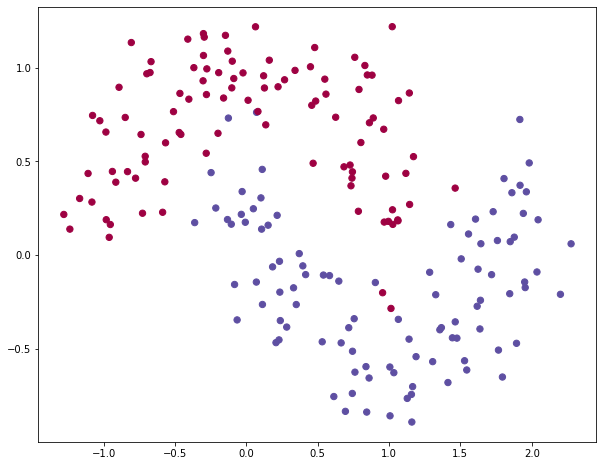

In [4]:
# Generate a dataset (make moons)
# %% 2 
np.random.seed(3) 
X, y = sklearn.datasets.make_moons(200, noise=0.20) 
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral);

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements.

Our goal is to train a Machine Learning classifier that predicts the correct class (male of female) given the x- and y- coordinates. Note that the data is not linearly separable, we can’t draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won’t be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.


### Logistic Regression
prove point try it out

Text(0.5, 1.0, 'Logistic Regression')

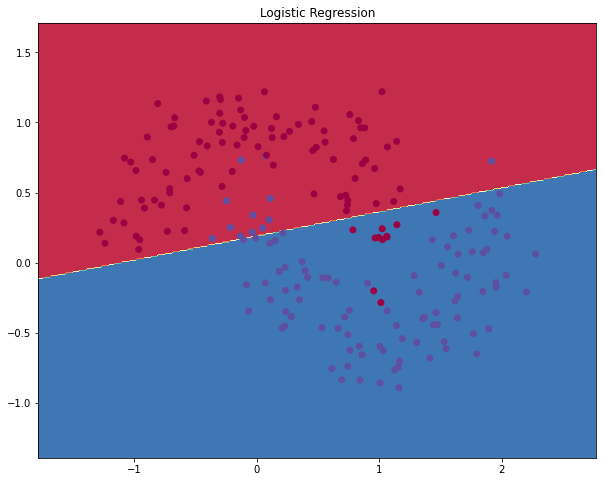

In [5]:
# %% 3 
# Train the logistic rgeression classifier 
clf = sklearn.linear_model.LogisticRegressionCV() 
clf.fit(X, y) 
 
# %% 4 
# Helper function to plot a decision boundary. 
# If you don't fully understand this function don't worry, it just generates the contour plot below. 
def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
 
# %% 12 
# Plot the decision boundary 
plot_decision_boundary(lambda x: clf.predict(x)) 
plt.title("Logistic Regression") 

# Its pretty bad at fitting moon shap

Let’s now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). 

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data.

We also need to pick an activation function for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are tanh, the sigmoid function, or ReLUs. We will use tanh, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of \tanh x is 1-\tanh^2 x. This is useful because it allows us to compute \tanh x  once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the softmax, which is simply a way to convert raw scores to probabilities. If you’re familiar with the logistic function you can think of softmax as its generalization to multiple classes.

#### Learning the Parameters
Learning the parameters for our network means finding parameters (W_1, b_1, W_2, b_2) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the loss function. A common choice with the softmax output is the categorical cross-entropy loss (also known as negative log likelihood). If we have N training examples and C classes then the loss for our prediction y_hat with respect to the true labels y.

sum over training examples and add to loss if we predicted the incorrect class.  The further away the prob dist (y correct and y predictions) greater the loss.   Find parameters and minimize this.

Use gradient decent to find the minimum. Use batch with fixed learning rate.  SGD - stochasitc gradient decent and minibatch gradient decent perform better. 

Gradient descent needs the gradients (vector of derivatives) of loss function wrt parameters (w1, w2, b1, b2).  To calculate this use backprop algoithm - way to calculate gradients starting from output. 

In [6]:
# Implementation

# %% 15 
num_examples = len(X) # training set size 
nn_input_dim = 2 # input layer dimensionality 
nn_output_dim = 2 # output layer dimensionality 
 
# Gradient descent parameters (I picked these by hand) 
epsilon = 0.01 # learning rate for gradient descent 
reg_lambda = 0.01 # regularization strength 

In [7]:
# impliment the loss function defined on web link (partial derivatives of loss func) 
# %% 7 
# Helper function to evaluate the total loss on the dataset 
def calculate_loss(model): 
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2'] 
    # Forward propagation to calculate our predictions 
    z1 = X.dot(W1) + b1 
    a1 = np.tanh(z1) 
    z2 = a1.dot(W2) + b2 
    exp_scores = np.exp(z2) 
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    # Calculating the loss 
    corect_logprobs = -np.log(probs[range(num_examples), y]) 
    data_loss = np.sum(corect_logprobs) 
    # Add regulatization term to loss (optional) 
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) 
    return 1./num_examples * data_loss 

In [8]:
# implement helper function to calculate output of the networkd (forward propagation as defined above - returns class with highest prob)

# %% 8 
# Helper function to predict an output (0 or 1) 
def predict(model, x): 
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2'] 
    # Forward propagation 
    z1 = x.dot(W1) + b1 
    a1 = np.tanh(z1) 
    z2 = a1.dot(W2) + b2 
    exp_scores = np.exp(z2) 
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    return np.argmax(probs, axis=1) 



In [9]:
# Train the nueral network
# %% 16 
# This function learns parameters for the neural network and returns the model. 
# - nn_hdim: Number of nodes in the hidden layer 
# - num_passes: Number of passes through the training data for gradient descent 
# - print_loss: If True, print the loss every 1000 iterations 
def build_model(nn_hdim, num_passes=20000, print_loss=False): 
 
    # Initialize the parameters to random values. We need to learn these. 
    np.random.seed(0) 
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) 
    b1 = np.zeros((1, nn_hdim)) 
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim) 
    b2 = np.zeros((1, nn_output_dim)) 
 
    # This is what we return at the end 
    model = {} 
 
    # Gradient descent. For each batch... 
    for i in range(0, num_passes): 
 
        # Forward propagation 
        z1 = X.dot(W1) + b1 
        a1 = np.tanh(z1) 
        z2 = a1.dot(W2) + b2 
        exp_scores = np.exp(z2) 
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
 
        # Backpropagation 
        delta3 = probs 
        delta3[range(num_examples), y] -= 1 
        dW2 = (a1.T).dot(delta3) 
        db2 = np.sum(delta3, axis=0, keepdims=True) 
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2)) 
        dW1 = np.dot(X.T, delta2) 
        db1 = np.sum(delta2, axis=0) 
 
        # Add regularization terms (b1 and b2 don't have regularization terms) 
        dW2 += reg_lambda * W2 
        dW1 += reg_lambda * W1 
 
        # Gradient descent parameter update 
        W1 += -epsilon * dW1 
        b1 += -epsilon * db1 
        W2 += -epsilon * dW2 
        b2 += -epsilon * db2 
 
        # Assign new parameters to the model 
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2} 
 
        # Optionally print the loss. 
        # This is expensive because it uses the whole dataset, so we don't want to do it too often. 
        if print_loss and i % 1000 == 0: 
          print("Loss after iteration %i: %f" %(i, calculate_loss(model))) 
 
    return model 

Loss after iteration 0: 0.418627
Loss after iteration 1000: 0.046520
Loss after iteration 2000: 0.043340
Loss after iteration 3000: 0.041303
Loss after iteration 4000: 0.039900
Loss after iteration 5000: 0.038971
Loss after iteration 6000: 0.038373
Loss after iteration 7000: 0.037989
Loss after iteration 8000: 0.037739
Loss after iteration 9000: 0.037574
Loss after iteration 10000: 0.037463
Loss after iteration 11000: 0.037387
Loss after iteration 12000: 0.037334
Loss after iteration 13000: 0.037296
Loss after iteration 14000: 0.037269
Loss after iteration 15000: 0.037250
Loss after iteration 16000: 0.037236
Loss after iteration 17000: 0.037225
Loss after iteration 18000: 0.037218
Loss after iteration 19000: 0.037212


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

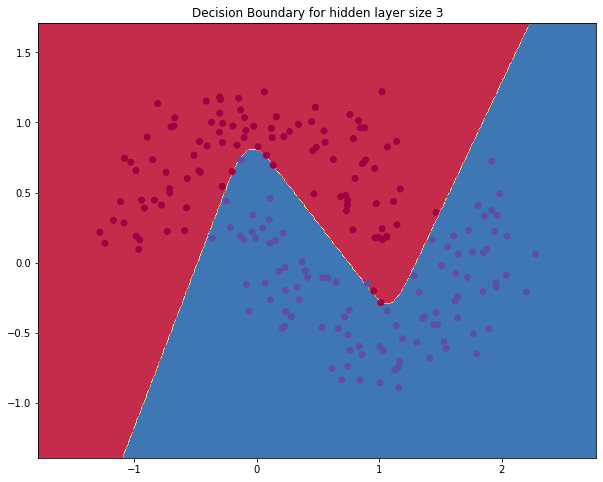

In [10]:
# A network with hidden layer of size 3

# %% 17 
# Build a model with a 3-dimensional hidden layer 
model = build_model(3, print_loss=True) 
 
# Plot the decision boundary 
plot_decision_boundary(lambda x: predict(model, x)) 
plt.title("Decision Boundary for hidden layer size 3") 

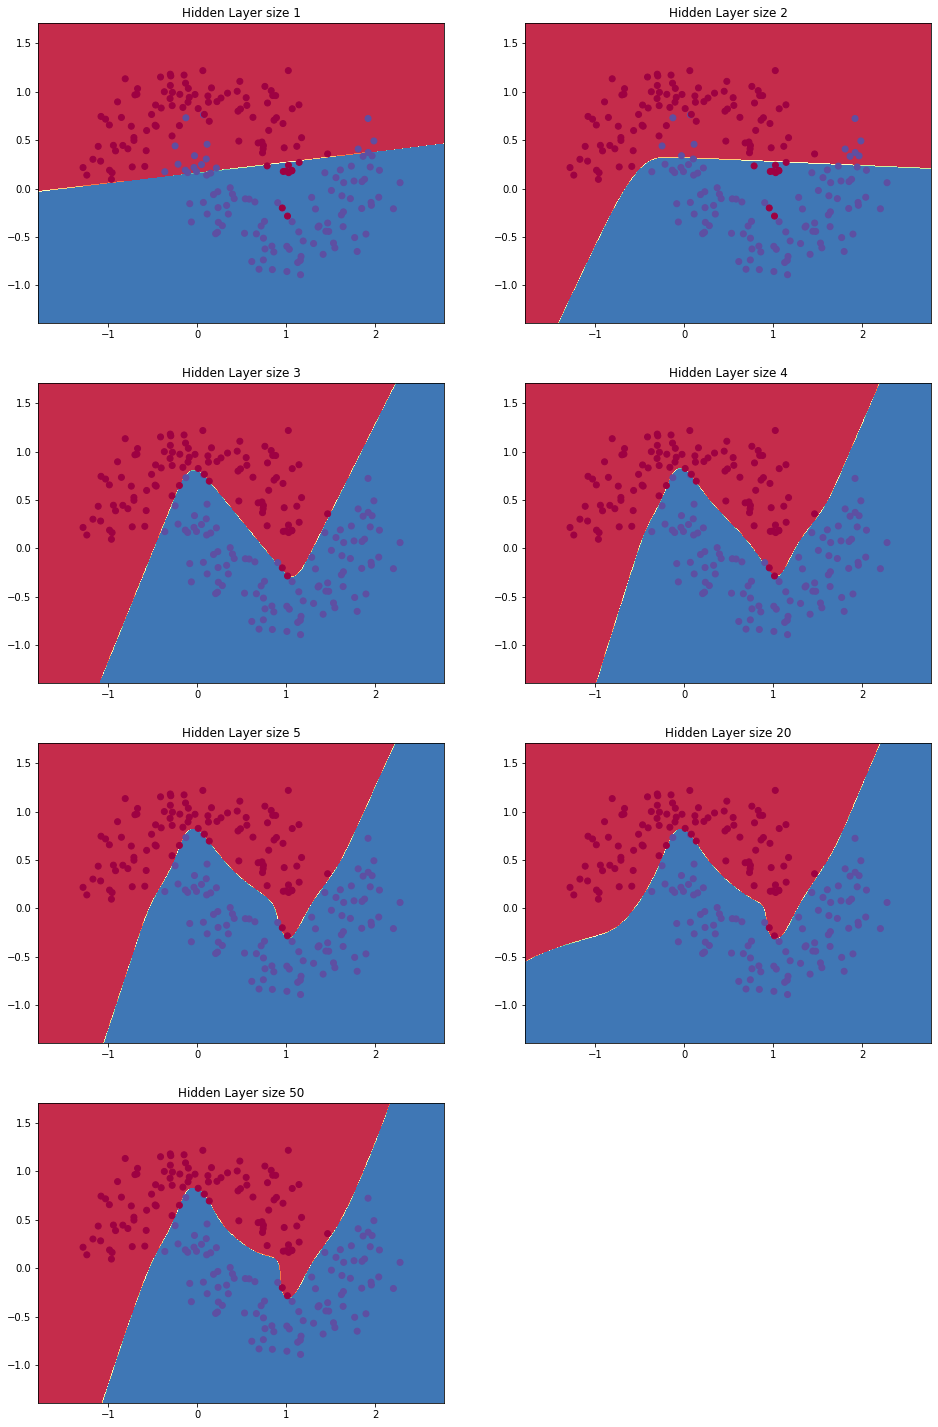

In [12]:
# Varying the hidden layer size:

# %% 14 
plt.figure(figsize=(16, 32)) 
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50] 
for i, nn_hdim in enumerate(hidden_layer_dimensions): 
    plt.subplot(5, 2, i+1) 
    plt.title('Hidden Layer size %d' % nn_hdim) 
    model = build_model(nn_hdim) 
    plot_decision_boundary(lambda x: predict(model, x)) 
plt.show()

We can see that a hidden layer of low dimensionality nicely captures the general trend of our data. Higher dimensionalities are prone to overfitting. They are “memorizing” the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better due to better generalization. We could counteract overfitting with stronger regularization, but picking the a correct size for hidden layer is a much more “economical” solution.

#### Exercises
Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent (more info) to train the network. Minibatch gradient descent typically performs better in practice.
2. We used a fixed learning rate \epsilon for gradient descent. Implement an annealing schedule for the gradient descent learning rate (more info).
3. We used a \tanh activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.